In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from exploration_utils import *
from eval_functions import *

In [9]:
material_data = pd.read_csv("result_data/material_perf_10.csv")

social_data = pd.read_csv("result_data/social_perf_10.csv")

physical_data = pd.read_csv("result_data/physical_perf_10.csv")

with open("truism_data/physical_data.json", "r") as f:
    physical_params = json.load(f)

with open("truism_data/material_data.json", "r") as f:
    material_params = json.load(f)

with open("truism_data/social_data.json", "r") as f:
    social_params = json.load(f)

In [10]:
filtered_material_data = material_data[(material_data["avg_binary_score"]==1.0) |
                                       (material_data["avg_binary_score"]==0.0)]

filtered_social_data = social_data[(social_data["avg_binary_score"]==1.0) |
                                   (social_data["avg_binary_score"]==0.0)]

filtered_physical_data = physical_data[(physical_data["avg_binary_score"]==1.0) |
                                       (physical_data["avg_binary_score"]==0.0)]

In [11]:
filtered_physical_data

,truism_number,perturbation,premise,avg_binary_score,avg_ratio_score
0,0,original,original,1.0,0.761914
1,0,original,asymmetric_premise,0.0,-0.925548
2,0,original,asymmetric_conclusion,0.0,-0.917618
3,0,negation,original,0.0,-0.725308
4,0,negation,asymmetric_premise,1.0,0.626366
...,...,...,...,...,...
472,19,negation_paraphrase,asymmetric_premise,0.0,-0.793112
473,19,negation_paraphrase,asymmetric_conclusion,0.0,-0.669244
474,19,negation_paraphrase_inversion,original,0.0,-0.780922
475,19,negation_paraphrase_inversion,asymmetric_premise,1.0,0.883004


In [30]:
def extract_labels(results, config):
    true_labels = []
    predicted_labels = []
    for i, row in results.iterrows():
        perturbation = row["perturbation"]
        premise = row["premise"]
        truism_num = row["truism_number"]
        truism_params = config[str(truism_num)]
        is_more = truism_params["is_more"]
        
        true_label = 1 if is_more else -1
        
        if perturbation in ["original", "paraphrase", "negation_antonym", "negation_paraphrase_inversion"]:
            if premise == "original":
                true_labels.append(true_label)
            else:
                true_label = -1*true_label
                true_labels.append(true_label)
            
        
        else:
            if premise == "original":
                true_label = -1*true_label
                true_labels.append(true_label)
            else:
                true_labels.append(true_label)
        
        if row["avg_binary_score"] > 0:
            predicted_labels.append(true_label)
        else:
            predicted_labels.append(-1*true_label)
        
    
    return true_labels, predicted_labels
        
                

In [31]:
mat_true_labels, mat_predicted_labels = extract_labels(filtered_material_data, material_params)
soc_true_labels, soc_predicted_labels = extract_labels(filtered_social_data, social_params)
phys_true_labels, phys_predicted_labels = extract_labels(filtered_physical_data, physical_params)

In [32]:
full_true_labels = []
full_predicted_labels = []

for label in mat_true_labels:
    full_true_labels.append(label)

for label in soc_true_labels:
    full_true_labels.append(label)

for label in phys_true_labels:
    full_true_labels.append(label)

for label in mat_predicted_labels:
    full_predicted_labels.append(label)

for label in soc_predicted_labels:
    full_predicted_labels.append(label)

for label in phys_predicted_labels:
    full_predicted_labels.append(label)

In [33]:
len(full_true_labels) == len(full_predicted_labels)

True

In [37]:
metrics = get_all_metrics(full_true_labels, full_predicted_labels)

In [61]:
def plot_confusion_matrix(cm, classes=None, normalize=True, small=True,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    # pylint: disable=line-too-long
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    Taken from : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Params:
        cm              (arr) : the confusion matrix to plot
        classes         (arr) : the various class labels
        normalize      (bool) : to normalize the probabilities or not
        title           (str) : title of plot
        cmap  (matplotlib.cm) : the color scheme to use for the confusion
                                matrix
    """
    if not classes:
        classes = [str(i) for i in range(len(cm))]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if not small:
        plt.figure(num=1, figsize=(20, 15))
    else:
        plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
#     plt.axhline(y,color='blue', linestyle="--")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Masked Word')
    plt.xlabel('Guessed Masked Word')
    plt.savefig("visual_data/confusion_matrix.pdf")
    plt.show()

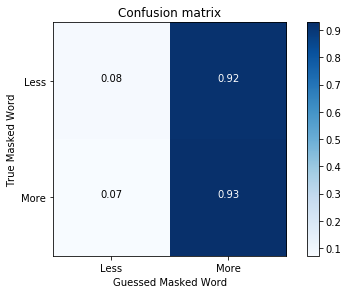

In [62]:
plot_confusion_matrix(metrics["confusion_matrix"], classes=["Less", "More"])

In [48]:
print(pretty_print_metrics(metrics))

1

accuracy: 0.502

precision: 
	all: ['0.532', '0.499']
	micro: 0.502
	macro: 0.516
	weighted: 0.516
	
recall: 
	all: ['0.081', '0.928']
	micro: 0.502
	macro: 0.504
	weighted: 0.502
	
f1_measure: 
	all: ['0.140', '0.649']
	micro: 0.502
	macro: 0.395
	weighted: 0.393
	
support: 
	y_true_dist: ['0.503', '0.497']
	y_true_count: 1425.000
	y_predicted_dist: ['0.076', '0.924']
	y_predicted_count: 1425.000
	

